# LSTM on Amazon Fine Food Reviews

In [5]:
import sqlite3

import gensim
%matplotlib inline
import pandas as pd
import numpy as np
import sqlite3
import re
import nltk
import matplotlib.pyplot as plt
from  nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score,log_loss
import warnings
warnings.filterwarnings('ignore')
# LSTM for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


In [6]:
#loading data
con = sqlite3.connect(r'/content/drive/My Drive/database.sqlite')
data = pd.read_sql_query('select * from REVIEWS where Score!=3',con)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
def change_labels(x):
    if x > 3:
        return 1
    return 0
temp_score = data['Score']
temp_score = temp_score.map(change_labels)
data['Score'] =  temp_score
data['Score'].head()

0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

In [8]:
#data cleanising
print('Number of data points before removing duplicates',data.shape[0])
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
clean_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print('Number of data points after removing duplicates',clean_data.shape[0])

Number of data points before removing duplicates 525814
Number of data points after removing duplicates 364173


In [9]:
clean_data=clean_data[clean_data['HelpfulnessNumerator']<=clean_data['HelpfulnessDenominator']]
print('Now the Number of data points are',clean_data.shape[0])

Now the Number of data points are 364171


In [0]:
#to remove HTML Tags
def clean_html(x):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', x)
    return cleantext
#  to remove unwanted charecteres like '!',',' etc.

def cleansen(x):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',x)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
stemmer = nltk.stem.SnowballStemmer('english')

In [11]:
import datetime

str1=' '
final_string=[]

s=''
start_time = datetime.datetime.now()
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    sent=clean_html(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleansen(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
               # if(cleaned_words.lower() not in stop_words):
                    s=(stemmer.stem(cleaned_words.lower()))
                    filtered_sentence.append(s)
               # else:
                #    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = " ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
clean_data['CleanedText']=final_string
print('Total time taken to clean the reviews',datetime.datetime.now()-start_time)

Total time taken to clean the reviews 0:07:53.717293


In [0]:
clean_data=clean_data.head(100000)

In [0]:
words = pd.DataFrame()
vocaby = pd.DataFrame()

In [0]:
#replacing words with frequency of thier occurances
vocab_words = []
for sent in clean_data['CleanedText'].values:
  for words in sent.split():
    vocab_words.append(words)


In [0]:
vocab_length = np.array(vocab_words).shape[0]

In [0]:
vocaby['words']=vocab_words

In [17]:
vocaby.head()

,words
0,this
1,witti
2,littl
3,book
4,make


In [0]:
top_words=5000

Words=vocaby['words'].value_counts().head(top_words)#reutrns a dictionary wth key as word and value as count

In [19]:
print(len(Words))
Words

5000


the            303098
and            218562
this           111739
for             92786
that            69652
have            61774
with            60071
you             57547
but             55865
are             53597
was             50386
not             50161
they            48631
like            41457
these           39569
tast            39441
them            37411
tea             35349
good            33012
use             32383
love            31112
product         30953
one             30654
flavor          30266
great           30043
veri            28606
it              28270
just            27810
can             27569
tri             26525
                ...  
gingeri            36
brace              36
bend               36
smother            36
uti                36
perish             36
unclear            36
huh                36
mileag             36
salmonella         36
patio              36
artisan            36
limp               36
structur           36
nap       

In [0]:
#fuction to replace words with counts 
def text_count(row):
    count = []
    for w in row['CleanedText'].split():
        if w in Words:
            count.append(Words[w]) 
        else:
            count.append(0)            
    return count

 

    
 

In [0]:
clean_data['countvectorize'] = clean_data.apply(lambda row: text_count(row),axis=1)

In [21]:
clean_data['countvectorize']

138706    [111739, 0, 13380, 688, 24074, 2237, 198, 122,...
138688    [776, 3246, 39569, 0, 688, 218562, 1327, 30309...
138689    [111739, 1143, 8356, 92786, 884, 959, 9892, 53...
138690    [111739, 30043, 13380, 688, 3246, 21441, 7107,...
138691    [111739, 688, 0, 16507, 303098, 5326, 303098, ...
138693    [122, 0, 688, 69652, 935, 303098, 0, 1122, 120...
138694    [2008, 249, 2681, 2485, 4419, 11450, 3246, 223...
138695    [1605, 111739, 688, 25097, 336, 218562, 6725, ...
138696    [28270, 30043, 688, 60071, 284, 78, 1189, 463,...
138697    [111739, 688, 4387, 7783, 218562, 50386, 3246,...
138687    [22615, 303098, 617, 753, 307, 218562, 81, 142...
138698    [303098, 5492, 89, 252, 3451, 303098, 689, 798...
138700    [30043, 688, 6646, 1111, 4053, 988, 3585, 1812...
138701    [12903, 6555, 31112, 4631, 5229, 218562, 6490,...
138702    [111739, 688, 50386, 8879, 683, 3422, 92786, 1...
138703    [11721, 5133, 1854, 788, 111739, 688, 3528, 25...
138704    [111739, 688, 4856, 245, 157, 

In [0]:
# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(clean_data['countvectorize'].values,
                                                            clean_data['Score'],
                                                            test_size=0.3,
                                                            shuffle=False,
                                                            random_state=0)

In [23]:
print("Total number words present in first review:\n",len(x_train[1]))
print()
print("List of word indexes present in first review:\n", x_train[1])
print()

Total number words present in first review:
 40

List of word indexes present in first review:
 [776, 3246, 39569, 0, 688, 218562, 1327, 303098, 15418, 0, 617, 69652, 117, 37411, 218562, 31112, 37411, 2237, 31112, 37411, 14611, 4754, 1322, 303098, 5895, 1246, 1989, 303098, 0, 5674, 3386, 68, 218562, 6852, 7883, 3028, 7393, 303098, 253, 4147]



In [24]:
max_review_length = 500
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print("Total number words present in first review after padding:\n",len(x_train[1]))
print()
print("List of word indexes present in first review padding:\n", x_train[1])
print()

Total number words present in first review after padding:
 500

List of word indexes present in first review padding:
 [     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0 

In [0]:
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import L1L2
# Batch size 
batch_size = 192 

# Number of time whole data is trained
epochs = 5

# Embedding vector size
embedding_vecor_length = 32

# Bias regularizer value - we will use elasticnet
reg = L1L2(0.01, 0.01)

# Plot train and cross validation loss
def plot_train_cv_loss(trained_model, epochs, colors=['b']):
    fig, ax = plt.subplots(1,1)    
    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')
    x_axis_values = list(range(1,6))

    validation_loss = trained_model.history['val_loss']
    train_loss = trained_model.history['loss']   
    
    ax.plot(x_axis_values, validation_loss, 'b', label="Validation Loss")
    ax.plot(x_axis_values, train_loss, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

Model 1 with 1 Lstm layer

In [26]:
# Instantiate sequntial model
model = Sequential()

# Add Embedding Layer
model.add(Embedding(vocab_length, embedding_vecor_length, input_length=max_review_length))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer
model.add(LSTM(100))

# Add dropout
model.add(Dropout(0.20))

# Add Dense Layer
model.add(Dense(1, activation='sigmoid'))

# Summary of the model
print("Model Summary: \n")
model.summary()
print()
print()

# Compile the model 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Run the model
trained_model = model.fit(x_train, np.array(y_train), batch_size = batch_size, epochs = epochs, verbose=1, validation_data=(x_test, y_test))

Model Summary: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           183078368 
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 183,131,797
Trainable params: 183,131,733
Non-trainable params: 64
____________________________________________

In [27]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test accuracy: {0:.2f}%'.format(score[1]*100))

Test accuracy: 93.33%


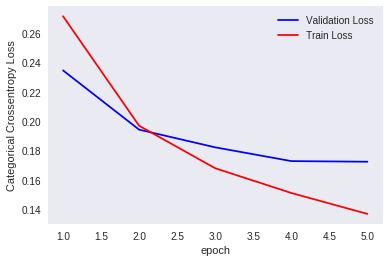

In [28]:
plot_train_cv_loss(trained_model, epochs)

we are getting test accuracy of 93.33 and after 3 epochs model is over fitting

Model 2 with 2 Lstm Layers

In [27]:
# Instantiate sequntial model
model = Sequential()

# Add Embedding Layer
model.add(Embedding(vocab_length, embedding_vecor_length, input_length=max_review_length))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 1
model.add(LSTM(100,return_sequences=True,bias_regularizer=reg))

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 2
model.add(LSTM(100))

# Add dropout
model.add(Dropout(0.20))




model.add(Dense(1, activation='sigmoid'))
# Summary of the model
print("Model Summary: \n")
model.summary()
print()
print()

# Compile the model 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Run the model
trained_model = model.fit(x_train, np.array(y_train), batch_size = batch_size, epochs = epochs, verbose=1, validation_data=(x_test, y_test))

Model Summary: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           183078368 
_________________________________________________________________
batch_normalization_2 (Batch (None, 500, 32)           128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0   

In [28]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test accuracy: {0:.2f}%'.format(score[1]*100))

Test accuracy: 93.30%


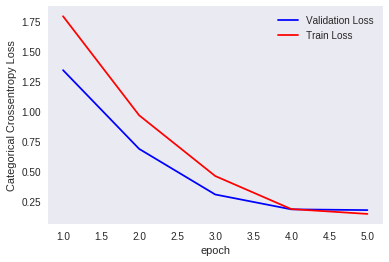

In [32]:
plot_train_cv_loss(trained_model, epochs)

We can see we are getting 93.30 accuracy and after 4 epochs model is not over fitting

In [ ]:
Conclusion Table:

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Model", "Train Accuracy", "Test accuracy", "Is Over Fitting"]
x.add_row(["Model1", 94.7, 93.33, 'Yes'])
x.add_row(["Model2", 94.34, 93.30, 'No'])
print(x)

+--------+----------------+---------------+-----------------+
| Model  | Train Accuracy | Test accuracy | Is Over Fitting |
+--------+----------------+---------------+-----------------+
| Model1 |      94.7      |     93.33     |       Yes       |
| Model2 |     94.34      |      93.3     |        No       |
+--------+----------------+---------------+-----------------+
